In [2]:
# Importations nécessaires
import os
import numpy as np
import cv2
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt



In [3]:
# Chemins des données
data_dir = "./wheat_disease"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Hyperparamètres
IMG_SIZE = (224, 224)
BATCH_SIZE = 32



In [4]:
# Fonction pour appliquer CLAHE (prétraitement)
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# Fonction pour appliquer color thresholding
def remove_background_color_thresholding(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([35, 50, 50])  # Lower bound for green in HSV
    upper_green = np.array([85, 255, 255])  # Upper bound for green in HSV
    mask = cv2.inRange(hsv, lower_green, upper_green)
    mask_inv = cv2.bitwise_not(mask)
    result = cv2.bitwise_and(image, image, mask=mask_inv)
    return result

# Charger et prétraiter les données
def load_data(data_dir, apply_clahe_flag=False, apply_color_thresholding=False):
    original_images, preprocessed_images, labels = [], [], []
    for label, class_dir in enumerate(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_dir)
        if not os.path.isdir(class_path):  # Ignorer les fichiers qui ne sont pas des répertoires
            continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:  # Vérifier si l'image a été lue correctement
                print(f"Warning: Unable to read image {img_path}. Skipping...")
                continue
            
            # Resize the original image
            img_resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_CUBIC)
            original_images.append(img_resized / 255.0)  # Normalisation
            
            # Preprocess the image (CLAHE and color thresholding)
            preprocessed_img = img_resized.copy()
            if apply_color_thresholding:
                preprocessed_img = remove_background_color_thresholding(preprocessed_img)
            if apply_clahe_flag:
                preprocessed_img = apply_clahe(preprocessed_img)
            preprocessed_images.append(preprocessed_img / 255.0)  # Normalisation
            
            labels.append(label)
    return np.array(original_images), np.array(preprocessed_images), np.array(labels)


In [5]:
# Charger les données avec les images originales et prétraitées
X_train_original, X_train_preprocessed, y_train = load_data(train_dir, apply_clahe_flag=True, apply_color_thresholding=True)
X_test_original, X_test_preprocessed, y_test = load_data(test_dir, apply_color_thresholding=True)

In [6]:

# One-hot encoding des labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Diviser les données en ensembles d'entraînement et de validation
X_train_original, X_val_original, X_train_preprocessed, X_val_preprocessed, y_train, y_val = train_test_split(
    X_train_original, X_train_preprocessed, y_train, test_size=0.2, random_state=42
)


In [7]:

# Créer un modèle DenseNet201 pour l'extraction de features
def create_feature_extractor(input_shape):
    base_model = DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    x = GlobalAveragePooling2D()(base_model.output)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Extraire les features
input_shape = (224, 224, 3)  # 3 channels for both original and preprocessed
feature_extractor_original = create_feature_extractor(input_shape)
feature_extractor_preprocessed = create_feature_extractor(input_shape)

def extract_features(model, images, batch_size=32):
    features = []
    for start in range(0, len(images), batch_size):
        end = start + batch_size
        batch = images[start:end]
        batch_features = model.predict(batch)
        features.append(batch_features)
    return np.vstack(features)


In [8]:
# Extraire les features pour les ensembles d'entraînement, de validation et de test
X_train_features_original = extract_features(feature_extractor_original, X_train_original)
X_train_features_preprocessed = extract_features(feature_extractor_preprocessed, X_train_preprocessed)

D:\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3

D:\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


D:\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_708']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3

D:\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_708']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


In [9]:

X_val_features_original = extract_features(feature_extractor_original, X_val_original)
X_val_features_preprocessed = extract_features(feature_extractor_preprocessed, X_val_preprocessed)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [10]:

X_test_features_original = extract_features(feature_extractor_original, X_test_original)
X_test_features_preprocessed = extract_features(feature_extractor_preprocessed, X_test_preprocessed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:
# Concatenate the features
X_train_features = np.concatenate([X_train_features_original, X_train_features_preprocessed], axis=-1)
X_val_features = np.concatenate([X_val_features_original, X_val_features_preprocessed], axis=-1)
X_test_features = np.concatenate([X_test_features_original, X_test_features_preprocessed], axis=-1)


In [12]:

# Convertir les labels one-hot en labels entiers pour ADASYN et XGBoost
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)


In [18]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# Ensemble learning
rf = RandomForestClassifier(n_estimators=50, max_features="log2", class_weight="balanced", random_state=1, min_samples_leaf=2, min_samples_split=5, bootstrap=True, criterion="gini", oob_score=True)
dt = DecisionTreeClassifier(max_depth=200, class_weight="balanced", random_state=0, min_samples_leaf=1, min_samples_split=2, criterion="gini", splitter="best", ccp_alpha=0.2, min_impurity_decrease=0.2)
svm = SVC(kernel="rbf", C=10, gamma=0.0001, class_weight="balanced", probability=True, tol=0.001, cache_size=256, max_iter=-1, decision_function_shape="ovr", break_ties=True)

In [19]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
ensemble_model = VotingClassifier(estimators=[("RF", rf), ("DT", dt), ("SVM", svm)], voting="hard", weights=[1, 2, 3], n_jobs=-1, verbose=2, flatten_transform=True)



In [20]:
# Train ensemble model
ensemble_model.fit(X_train_features, np.argmax(y_train, axis=1))

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_features='log2',
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=50,
                                                     oob_score=True,
                                                     random_state=1)),
                             ('DT',
                              DecisionTreeClassifier(ccp_alpha=0.2,
                                                     class_weight='balanced',
                                                     max_depth=200,
                                                     min_impurity_decrease=0.2,
                                                     random_state=0)),
                             ('SVM',
                              SVC(C=10, break_ties=True, cache_size=256,
                                  class_weight='balanced', gamma=0.0001,
                                  probability=True))],
                 n_jobs=-1, verbose=2, weights=[1, 2, 3])

In [21]:
# Validate ensemble model
y_val_pred = ensemble_model.predict(X_val_features)

In [22]:
val_acc = accuracy_score(np.argmax(y_val, axis=1), y_val_pred)
print(f"Validation Accuracy: {val_acc}")

Validation Accuracy: 0.9932088285229203


In [23]:
# Test ensemble model
y_test_pred = ensemble_model.predict(X_test_features)
print(classification_report(np.argmax(y_test, axis=1), y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       226
           1       1.00      1.00      1.00       279
           2       1.00      1.00      1.00       232

    accuracy                           1.00       737
   macro avg       1.00      1.00      1.00       737
weighted avg       1.00      1.00      1.00       737



In [24]:
# Calculate test accuracy
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)
print(f"Test Accuracy: {test_accuracy}")


Test Accuracy: 0.9986431478968792


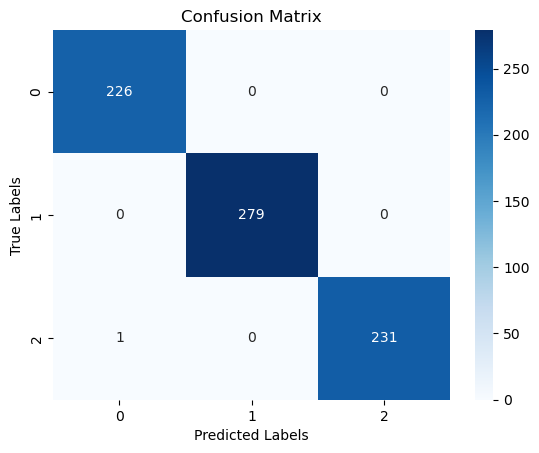

In [25]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()